# Student name and e-mail

name : 

e-mail : 

In [1]:
USE_GOOGLE_COLAB = False

# python modules

In [2]:
%load_ext cython

In [3]:
import matplotlib
# matplotlib.use('Qt5Agg')
from IPython.display import HTML
import matplotlib.pyplot as plt
from matplotlib import animation

import cython
import datetime
import numpy as np
import os
try:
    import yaml
    HAS_YAML=True
    display('Good News, YAML format accepted')
except ImportError:
    import json as js
    HAS_YAML=False
    display('only json accepted')

%matplotlib inline

'Good News, YAML format accepted'

function used to generate animations and compute computation time

# Additional functions

<font size=3>
    Functions defined here have been made to simplify representation of outputs. These functions are not part of the labs and can be used directly
</font>

In [4]:
from utils.timer import Timer
from utils.plotting import plot_results, plot_profile, figformat, plot_2d_profile

In [5]:
from utils.file import save_outputs

def save_with_params(output, params):
    prefix = ''
    if params.get('C', None) is not None:
        prefix = 'diff_'
    if params.get('V', None) is not None:
        prefix += 'adv_'
    prefix += '{0:03d}_'.format(params['Nx'])
    save_outputs(output, prefix=prefix)

In [6]:
def load_from_string(params_str:str):
    """
    function used to load parameters from a string and load it into a dict used by simulations
    return : dict or ValueError if scheme is not correct
    """
    if not HAS_YAML:
        data = js.loads(params_str)
    else:
        data = yaml.safe_load (params_str)
    data['V'] = np.double(data['V'])
    try:
        data['Nx'] = np.int(data['Nx'])
    except TypeError:
        raise ValueError('Nx Value missing or not written as a number')
    try:
        data['Ny'] = np.int(data['Ny'])
    except TypeError:
        raise ValueError('Ny Value missing or not written as a number')
    except KeyError:
        print('Ny key not found')
    data['scheme'] = data['scheme'].lower().strip()
    if data['scheme'] not in ('eule', 'euli', 'rk2', 'rk4', 'cn'):
        raise ValueError('unknown time scheme')
    return data

# Finite difference solver imported from the h2d directory

In [7]:
os.getcwd()
folder = os.path.split(os.getcwd())
if ('h2d' in folder) or ('advdiff' in folder):
    try:
        os.mkdir('../run')
    except FileExistsError:
        pass
    os.chdir('../run')
elif ('run' in folder):
    pass
elif ('python' in folder):
    try:
        os.mkdir('./run')
    except FileExistsError:
        pass
    os.chdir('./run')
    
display(HTML('<font size=4> data saved in the ./run subfolder </font>'))

In [8]:
%%cython
import numpy as np
import pyximport
import setuptools

pyximport.install(reload_support=True, setup_args = {'include_dirs': np.get_include()})

In [9]:
import importlib
os.chdir('../h2d')
try: 
    importlib.reload(h2d); import h2d
    importlib.reload(h2d_spectral); import h2d_spectral 
except NameError:
    import h2d
    import h2d_spectral 
os.chdir('../run')

display(HTML('H2D imported in current notebook'))

## definition of simulation's parameters

In [10]:

# list of parameters used in both advdiff et H2D.
# Remark : the # starting line indicates a comment and is not necessary

# definition of parameter input to be used
"""
# time step
dt: .000001

# x step
dx:  .015

# y step (used only for H2D simulations)
dy: .01

# Points in X direction
Nx:  128

# Points in Y direction
Ny: 128

# modes in Y direction
Nm:  32

# wave number in Y direction
ky: .1

# end time
Tmax: .00001

# output time
Toutput: .000001

# diffusion coefficient
C:  .02

# advection coefficient
V:  -.2

# time scheme
# can be
# eule for euler explicit (default)
# euli for euler implicit
# RK2 for Runge-Kutta 2
# RK4 for Runge-Kutta 4
# CN for Cranck-Nicholson
scheme: eule
"""
;

''

# Section 0 : Introduction

Solve diffusion equation : 
$$\Large \frac{\partial u(x,y,t)}{\partial t}  = C\frac{\partial^2 u(x,y,t)}{\partial x^2}+C\frac{\partial^2 u(x,y,t)}{\partial y^2}$$
$$\Large u(x,y, t=0) = u_0(x,y) $$
$$\Large u(0,y, t) = u(L_x,y, t)=0 $$
$$\Large u(x,0, t) = u(x, L_y, t) $$

<font size=4>
<p>First, we define parameters in a string which will then be used for the simulation. All the parameters are described in the upper cell.
This variable is converted to an usable dict through the function load_from_string.
    </p>
</font>

In [11]:
params_ex_diff_str = """{
"C": 0.04,
"Nx": 16,
"Ny": 16,
"Tmax": .000001,
"Toutput": .0000001, 
"V": 0,
"dt": 0.000000001,
"dx": 0.1,
"dy": 0.1,
"scheme": "eule"
}
"""
params_ex_diff = load_from_string(params_ex_diff_str)
display(params_ex_diff)

{'C': 0.04,
 'Nx': 16,
 'Ny': 16,
 'Tmax': 1e-06,
 'Toutput': 1e-07,
 'V': 0.0,
 'dt': 1e-09,
 'dx': 0.1,
 'dy': 0.1,
 'scheme': 'eule'}

<font size=4>
    If YAML format is accepted, parameters can be written following this format. If YAML is not recognized, you will have an error message.
</font>

In [12]:
params_ex_diff_str = """
C: 0.04
Nx: 16
Ny: 16
Tmax: .0001
Toutput: .00001 
V: 0
dt: 0.000000001
dx: 0.1
dy: 0.1
scheme: eule
# boundary can be default to use default boundaries implemented
# or null to use the function null_bc (as asked in section 3.1)
boundary: default
"""
params_ex_diff = load_from_string(params_ex_diff_str)
display(params_ex_diff)

{'C': 0.04,
 'Nx': 16,
 'Ny': 16,
 'Tmax': 0.0001,
 'Toutput': 1e-05,
 'V': 0.0,
 'dt': 1e-09,
 'dx': 0.1,
 'dy': 0.1,
 'scheme': 'eule',
 'boundary': 'base'}

<font size=4> 
    To run a new simulation you just need to use the function simulate with the parameters written previously as argument
</font>

In [13]:
def initfield_2D(x: np.array, y: np.array):
    """
    generate initial profile for H2D simulations,
    :param x: meshgrid for X values
    :param y: meshgrid for Y values
    :return: 2D field
    """
    u0 = x+y
    return u0

In [14]:
output_ex_diff = h2d.simulate(**params_ex_diff, init=initfield_2D, verbose=False)

number of frames 10
loop time  in µs 923993
used time for 1 time step in µs: 9.24
Data saved to file : ./data_2D.npy


<font size=4> 
    To see the result as an animation you can use the function plot_results with the returned value from the function simulate as argument
</font>

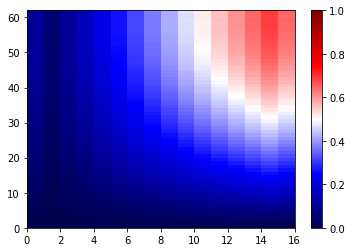

In [30]:
%matplotlib inline
plot_results(output_ex_diff)

<font size=4>
    to plot last snapshot
</font>

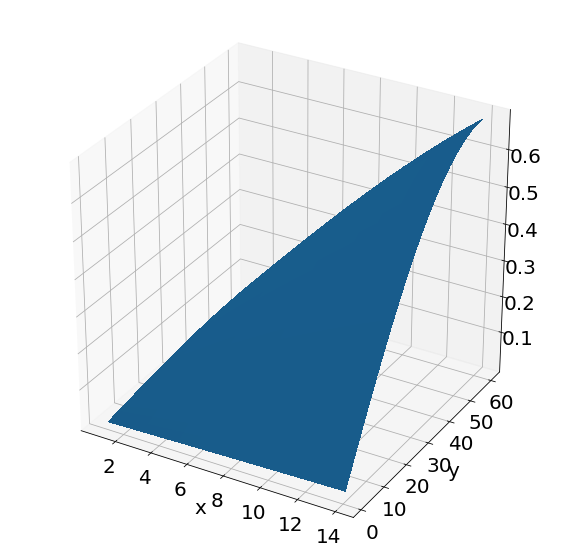

In [29]:
%matplotlib inline
plot_2d_profile(output_ex_diff, -1)

<font size=4>
    to plot evolution of max(u(x,y,t)) in time
</font>

In [17]:
from mpl_toolkits.mplot3d import Axes3D
from utils.tools import extract_max
figformat().apply()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

x = extract_max(output_ex_diff)[0]
y = extract_max(output_ex_diff)[1]
m = extract_max(output_ex_diff)[2]
t = 1+np.arange(0, m.shape[0])
ax.scatter(x,y,m, c=t, marker='o')
# set log scale in y
# ax.set_yscale('log')
# set log scale in x
# ax.set_xscale('log')

plt.xlabel('x')
plt.ylabel('y')

plt.show()

### Section 1 : diffusion in real space

In [18]:
# fill this parameters to resolve time evolution of 1D diffusion

params_for_diff = """
C: 
Nx: 
Tmax: 
Toutput: 
V: 0
dt: 
dx: 
scheme: eule
"""
params_diff = load_from_string(params_for_diff)
display(params_diff)

ValueError: Nx Value missing or not written as a number

### Section 2 : diffusion using Fourier decomposition

When using Fourier decomposition, this time the main module is not any more h2d but h2d_spectral.
So to run a new simulation you have to use the function h2d.simulate.

Please note that the initial condition must be written as the function in real and not Fourier space. Moreover, outputs/snapshots are by default transformed to real spaces expressions

In [ ]:
params_ex_diff_fourier_str = """
C: 0.04
Nx: 16
Ny: 16
Nm: 4
Tmax: .0001
Toutput: .00001 
V: 0
dt: 0.000000001
dx: 0.1
ky: 0.1
scheme: eule
# boundary can be default to use default boundaries implemented
# or null to use the function null_bc (as asked in section 3.1)
boundary: default
"""
params_ex_diff_fourier = load_from_string(params_ex_diff_fourier_str)
display(params_ex_diff_fourier)

In [21]:
output_ex_diff_fourier = h2d_spectral.simulate(**params_ex_diff, init=initfield_2D, verbose=False)

stability numbers : 
advection in x direction: 0.0
advection in y direction: 0.0
diffusion in x direction: 3.9999999999999994e-09
diffusion in y direction: 3.9999999999999994e-09
number of frames 10
loop time  in µs 427551
used time for 1 time step : 4.28
Data saved to file : ./data_2D.npy


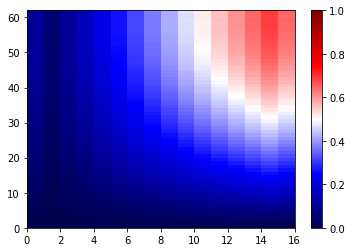

In [28]:
%matplotlib inline

plot_results(output_ex_diff_fourier, -1)

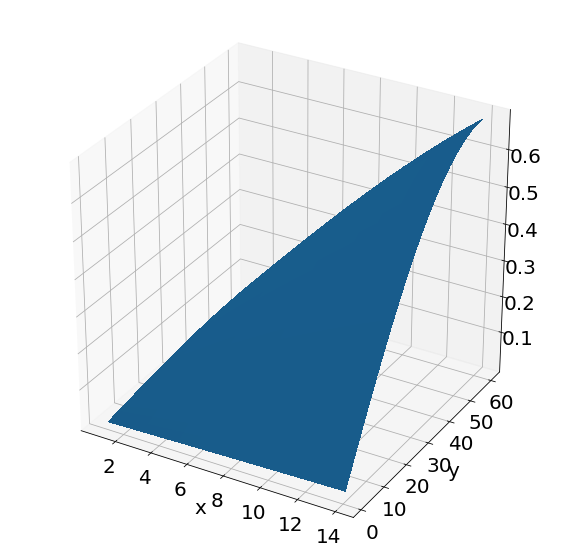

In [27]:
%matplotlib inline

plot_2d_profile(output_ex_diff_fourier, -1)